In [1]:
import VariationalBayes as vb
from VariationalBayes.SparseObjectives import SparseObjective, Objective
from VariationalBayes.Models.NormalMixture import normal_mixture as mix

import math

import autograd
import autograd.numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import time

from copy import deepcopy
import scipy as sp
from scipy import optimize
from scipy import stats

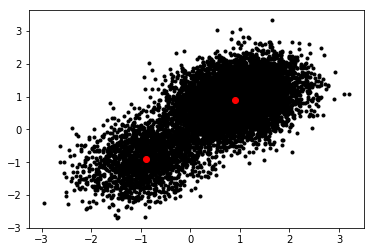

In [2]:
# Number of data points:
num_obs = 10000

# Dimension of observations:
d_num = 2

# Number of clusters:
k_num = 2

mu_scale = 3
noise_scale = 0.5

true_pi = np.linspace(0.2, 0.8, k_num)
true_pi = true_pi / np.sum(true_pi)

mu_prior_mean = np.full(d_num, 0.)
mu_prior_cov = np.diag(np.full(d_num, mu_scale ** 2))
mu_prior_info = np.linalg.inv(mu_prior_cov)
mu_spacing = np.linspace(-0.9, 0.9, k_num)
true_mu = np.array([ mu_spacing, mu_spacing]).T

true_sigma = np.array([ np.diag(np.full(d_num, noise_scale ** 2)) + np.full((d_num, d_num), 0.1) \
                        for k in range(k_num) ])
true_info = np.array([ np.linalg.inv(true_sigma[k, :, :]) for k in range(k_num) ])

x, true_z, true_z_ind = mix.generate_data(num_obs, true_mu, true_sigma, true_pi)

# visualize the dataz
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

In [3]:
global_params = vb.ModelParamsDict('global')
global_params.push_param(
    vb.PosDefMatrixParamVector(name='info', length=k_num, matrix_size=d_num))
global_params.push_param(
    vb.ArrayParam(name='mu', shape=(k_num, d_num)))
global_params.push_param(
    vb.SimplexParam(name='pi', shape=(1, k_num)))

local_params = vb.ModelParamsDict('local')
local_params.push_param(
    vb.SimplexParam(name='e_z', shape=(num_obs, k_num),
                    val=np.full(true_z.shape, 1. / k_num)))

params = vb.ModelParamsDict('mixture model')
params.push_param(global_params)
params.push_param(local_params)

true_init = False
if true_init:
    params['global']['info'].set(true_info)
    params['global']['mu'].set(true_mu)
    params['global']['pi'].set(true_pi)
else:
    params['global']['mu'].set(np.random.random(params['global']['mu'].shape()))
    
init_par_vec = params.get_free()
global_init_par_vec = params['global'].get_free()

print(params['global'])

global:
	info:
[[[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]]
	mu:
[[ 0.92338059  0.29002338]
 [ 0.11058052  0.5288157 ]]
	pi: [[ 0.5  0.5]]


In [4]:
prior_params = vb.ModelParamsDict()
prior_params.push_param(vb.VectorParam(name='mu_prior_mean', size=d_num, val=mu_prior_mean))
prior_params.push_param(vb.PosDefMatrixParam(name='mu_prior_info', size=d_num, val=mu_prior_info))
prior_params.push_param(vb.ScalarParam(name='alpha', val=2.0))
prior_params.push_param(vb.ScalarParam(name='dof', val=d_num + 2.0))

In [5]:
model = mix.Model(x, params, prior_params)
kl_obj = Objective(model.params['global'], model.kl)

In [6]:
def minimize_kl(kl_obj, init_x):
    vb_opt = optimize.minimize(
        kl_obj.fun_free,
        x0=init_x,
        jac=kl_obj.fun_free_grad,
        hess=kl_obj.fun_free_hessian,
        method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-8})

    print('done')
    return vb_opt

vb_opt = minimize_kl(kl_obj, global_init_par_vec)
print(kl_obj.fun_free(vb_opt.x))

done
3948.40034414


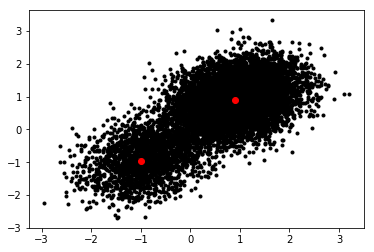

In [7]:
# Check that the solution looks sensible.
model.params['global'].set_free(vb_opt.x)
model.optimize_z()

mu_fit = model.params['global']['mu'].get()
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(mu_fit[k, 0], mu_fit[k, 1], 'ro')

In [10]:
moment_jac = model.get_moment_jacobian(vb_opt.x)
kl_hessian = kl_obj.fun_free_hessian(vb_opt.x)
sensitivity_operator = np.linalg.solve(kl_hessian, moment_jac.T)
print('Hessian done.')

Hessian done.


In [17]:
# def loglik_obs_set_z(global_free_par, model):
#     model.params['global'].set_free(global_free_par)
#     model.optimize_z()
#     return model.loglik_obs()

# eval_loglik_obs_set_z_jac = autograd.jacobian(loglik_obs_set_z)
# weight_jac = eval_loglik_obs_set_z_jac(vb_opt.x, model)
# data_sens = np.matmul(weight_jac, sensitivity_operator)
# print(data_sens.shape)

In [14]:
# Somewhat surprisingly, this is much faster than differentiating the vector directly!

def loglik_obs_set_z_weights(global_free_par, weights, model):
    model.params['global'].set_free(global_free_par)
    model.optimize_z()
    model.weights = weights
    return model.loglik()

eval_global_grad = autograd.jacobian(loglik_obs_set_z_weights, argnum=0)
eval_weight_jac = autograd.jacobian(eval_global_grad, argnum=1)
weight_jac = eval_weight_jac(vb_opt.x, model.weights, model)
data_sens = np.matmul(weight_jac.T, sensitivity_operator)
# print(data_sens.shape)

In [15]:
# Check sensitivity upon refitting with a new model with non-unity weights.
model_perturbed = deepcopy(model)
kl_obj_perturbed = Objective(model_perturbed.params['global'], model_perturbed.kl)

In [21]:
# Bootstrap weights
perturbed_weights = \
    np.random.multinomial(num_obs, [1/float(num_obs)] * num_obs, size=1).T

refit_time = time.time()
model_perturbed.weights = perturbed_weights
vb_opt_reweight = minimize_kl(kl_obj_perturbed, vb_opt.x)
model_perturbed.params['global'].set_free(vb_opt_reweight.x)
refit_time = time.time() - refit_time

print('Actual sensitivity:\t', 
      model_perturbed.get_interesting_moments(vb_opt_reweight.x) - \
      model.get_interesting_moments(vb_opt.x))
lin_time = time.time()
print('Predicted sensitivity:\t', np.squeeze(np.matmul(perturbed_weights.T - 1.0, data_sens)))
lin_time = time.time() - lin_time

# Of course, re-optimizing takes almost all the time.
print('Refit time:\t', refit_time)
print('Linear time:\t', lin_time)


done
Actual sensitivity:	 [ 0.00702403  0.01034102 -0.00220284 -0.02372507]
Predicted sensitivity:	 [ 0.00697165  0.01025742 -0.00252781 -0.02371236]
